In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.cluster import SpectralClustering as SC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
# %matplotlib notebook
import networkx as nx
from numpy import *
import random

In [164]:
X = iris.data
y = iris.target

In [165]:
X = X.tolist()

# Shuffle Dataset

In [166]:
node = []
for i in range(150):
    node.append(i)
random.shuffle(node)

In [167]:
for i in range(len(node)):
    for j in range(len(node)):
        if node[i]<node[j]:
            temp = X[i]
            X[i] = X[j]
            X[j] = temp
            temp2 =  y[i]
            y[i] = y[j]
            y[j] = temp2
            temp3 = node[i]
            node[i] = node[j]
            node[j] = temp3

# Distance Matrix

In [168]:
def euclidDistance(x1, x2, sqrt_flag=False):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res
def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            S[j][i] = S[i][j]
    return S

In [169]:
dis = calEuclidDistanceMatrix(X)

# Normalize

In [170]:
def normalization(w_AM):
    norm_w_AM = np.zeros((len(w_AM), len(w_AM[0])))
    norm_w_AM = norm_w_AM.tolist()
    w_AM_sum = []
    for i in range(len(w_AM[0])):
        w_AM_sum.append(sum(w_AM[:,i]))
    for i in range(len(w_AM)):
        for j in range(len(w_AM[0])):
            norm_w_AM[i][j] = w_AM[i][j]/w_AM_sum[j]
    norm_w_AM = np.array(norm_w_AM)
    return norm_w_AM

In [171]:
norm_dis = normalization(dis)

# Gaussian Kernal --> Similarity Matrix

In [172]:
sim = np.zeros((150,150))
sim = sim.tolist()
sigma = 2
for i in range(len(dis)):
    for j in range(len(dis)):
        sim[i][j] = np.exp(-(dis[i][j]**2)/(2*(sigma**2)))

# draw with similarity

In [173]:
G = nx.Graph()

In [174]:
for i in range(len(X)):
    for j in range(i+1, len(X)):
        if sim[i][j] > 0.9:
            G.add_edge(i, j)

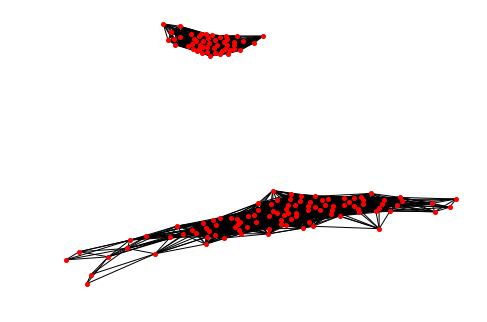

In [175]:
nx.draw(G,node_size = 16,)
plt.show()

# Adjacency Matrix and  with weight

In [176]:
AM = np.zeros((150,150))
w_AM = np.zeros((150,150))
AM = AM.tolist()
w_AM = w_AM.tolist()
for i in range(len(X)):
    for j in range(len(X)):
        if sim[i][j] > 0.9:
            AM[i][j] = 1
            w_AM[i][j] = sim[i][j]  #通过相似度得到带权邻接矩阵
        else:
            AM[i][j] = 0
            w_AM[i][j] = 0

# Degree Matrix

In [177]:
degree_matrix = np.zeros((150,150))
degree_matrix = degree_matrix.tolist()
for i in range(len(X)):
    for j in range(len(X)):
        if sim[i][j] > 0.9:
            degree_matrix[i][i]+=1

# Laplacian Matrices

In [178]:
L = np.zeros((150,150))
for i in range(len(L)):
    for j in range(len(L[0])):
        L[i][j] = degree_matrix[i][j] - w_AM[i][j]

In [179]:
from numpy.linalg import  *

In [180]:
eigenValue= eig(L)[0]
eigenVector = eig(L)[1]

In [181]:
len(eigenValue)
# eigenVector

150

In [182]:
#排序，取前50个最小的特征向量
for i in range(len(X)):
    for j in range(len(eigenVector[0])):
        for k in range(len(eigenVector[0])):
            if eigenVector[i][j] < eigenVector[i][k]:
                temp = eigenVector[i][j]
                eigenVector[i][j] = eigenVector[i][k]
                eigenVector[i][k] = temp

In [183]:
# eigenVector[0]

In [184]:
new_eigenVector = np.zeros((150,50))
new_eigenVector = new_eigenVector.tolist()

In [185]:
for i in range(len(new_eigenVector)):
    for j in range(len(new_eigenVector[0])):
        new_eigenVector[i][j] = eigenVector[i][j]
new_eigenVector = np.array(new_eigenVector)

In [186]:
Y = new_eigenVector

In [187]:
Y = normalization(Y)

# Clustering with K-means

In [188]:
#随机生成初始的质心（ng的课说的初始方式是随机选K个点）    
def randCent(dataSet, k):
    n = dataSet.shape[1]
    centroids = mat(zeros((k,n)))
    for j in range(n):
        minJ = min(dataSet[:,j])
        rangeJ = float(max(array(dataSet)[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * np.random.rand(k,1)
    return centroids

In [189]:
def kMeans(dataSet, k, distMeas=dis, createCent=randCent):
    m = dataSet.shape[0]
    clusterAssment = mat(zeros((m,2)))#create mat to assign data points 
                                      #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#for each data point assign it to the closest centroid
            minDist = inf
            minIndex = -1
            for j in range(k): #找到最近邻
                distJI = dis[j][i]
                if distJI < minDist:
                    minDist = distJI
                    minIndex = j
            if clusterAssment[i,0] != minIndex: 
                clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
#         print(centroids)
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]]#get all the point in this cluster
            centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean 
    return centroids, clusterAssment

In [190]:
myCentroids, clustAssing= kMeans(Y,3)

In [191]:
clustAssing = np.array(clustAssing)

In [192]:
len(clustAssing)

150

# Arrange and Draw

In [193]:
clus1 = []
clus2 = []
clus3 = []
for i in range(len(X)):
    if clustAssing[i][0]==0:
        clus1.append(i)
        continue
    if clustAssing[i][0]==1:
        clus2.append(i)
        continue
    if clustAssing[i][0]==2:
        clus3.append(i)

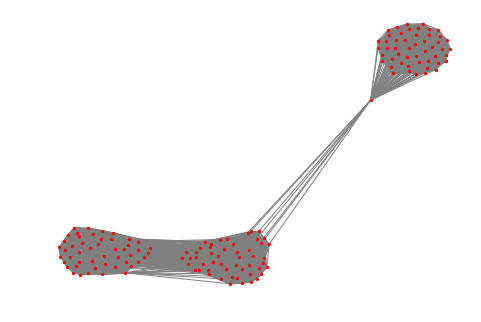

In [194]:
for i in clus1:
    for j in clus1:
        if i==j:
            continue
        G.add_edge(i, j)
# nx.draw(G,node_size = 16, node_shape='o', node_color='blue')
for i in clus2:
    for j in clus2:
        if i==j:
            continue
        G.add_edge(i, j, shape = 's')
# nx.draw(G,node_size = 16, node_shape='s', node_color='red')
for i in clus3:
    for j in clus3:
        if i==j:
            continue
        G.add_edge(i, j)
nx.draw(G,node_size = 10, linewidths=0.1, edge_color='gray')

In [195]:
print(len(clus1))
print(len(clus2))
print(len(clus3))

51
51
48


In [204]:
pre = []
for i in range(len(clustAssing)):
    if clustAssing[i][0] == 1:
        pre.append(0)
    elif clustAssing[i][0] == 0:
        pre.append(1)
    elif clustAssing[i][0] == 2:
        pre.append(2)

In [205]:
acc = 0
for i in range(len(X)):
    if pre[i] == y[i]:
        acc += 1
acc = acc/len(X)
print(acc)

0.9666666666666667


In [198]:
# clustAssing